In [2]:
import numpy as np
from matplotlib import pyplot as plt
from connectomics.config import get_cfg_defaults
from connectomics.data.dataset.build import _get_input
from connectomics.data.utils import seg2diffgrads, relabel, seg_widen_border,seg_to_targets

c:\python38\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Python38\Lib\site-packages\torchvision\image.pyd'. Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
# Load configs and dataset

# for 2D:
# cfg_filename = './configs/Cellpose/Cellpose-Base.yaml'

# for 3D:
cfg_filename = './configs/SNEMI/SNEMI-Base.yaml'

cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_filename)

In [4]:
# load data
volume, labels, _ = _get_input(cfg, 'train')
volume, labels = np.array(volume), np.array(labels)
volume.shape, labels.shape

None 1 ['train-input.tif']
volume shape (original): (100, 1024, 1024)
volume shape (after scaling and padding): (108, 1152, 1152)
label shape (after scaling and padding): (108, 1152, 1152)


((1, 108, 1152, 1152), (1, 108, 1152, 1152))

In [5]:
rand= np.random.randint(volume.squeeze().shape[0],size=(min(volume.squeeze().shape[0],5)))
if cfg.DATASET.DO_2D:
    sample_labels = labels[rand]
    sample_labels = sample_labels.squeeze()
else:
    sample_labels = labels[:,rand]
sample_labels.shape

(1, 5, 1152, 1152)

In [6]:
flows = [None]*sample_labels.shape[0]
for i in range(len(flows)):
    flows[i] = seg_to_targets(sample_labels[i],'7')[0]

In [7]:
def visualize_3d():
    for i in range(len(flows)):
        for z in range(len(flows[i][0])):
            plt.figure(figsize=(20,20))
            ax = plt.subplot(2,4,1)
            ax.set_title("Volume")
            plt.imshow(volume[i][z],cmap="gray")
            
            ax = plt.subplot(2,4,2)
            ax.set_title("Y Flow")
            plt.imshow(flows[0][0][z],cmap="gray")

            ax = plt.subplot(2,4,3)
            ax.set_title("X Flow")
            plt.imshow(flows[0][1][z],cmap="gray")

            ax = plt.subplot(2,4,4)
            ax.set_title("Cell Probability")
            plt.imshow(flows[0][2][z],cmap="gray")

            
def visualize_2d():
    for i in range(len(flows)):
        plt.figure(figsize=(20,20))
        ax = plt.subplot(2,4,1)
        ax.set_title("Volume")
        if volume[0].shape[0]==1:
            plt.imshow(volume[i],cmap="gray")
        else:
            plt.imshow(volume[i].transpose(1,2,0))
        
        ax = plt.subplot(2,4,2)
        ax.set_title("Y Flow")
        plt.imshow(flows[i][0],cmap="gray")

        ax = plt.subplot(2,4,3)
        ax.set_title("X Flow")
        plt.imshow(flows[i][1],cmap="gray")

        ax = plt.subplot(2,4,4)
        ax.set_title("Cell Probability")
        plt.imshow(flows[i][2],cmap="gray")

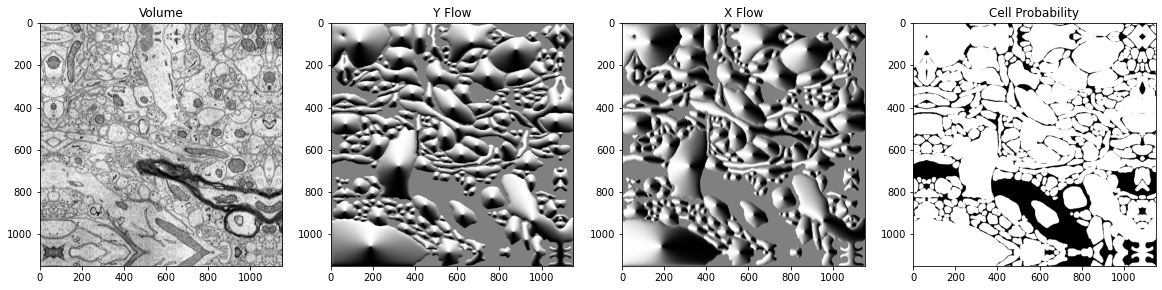

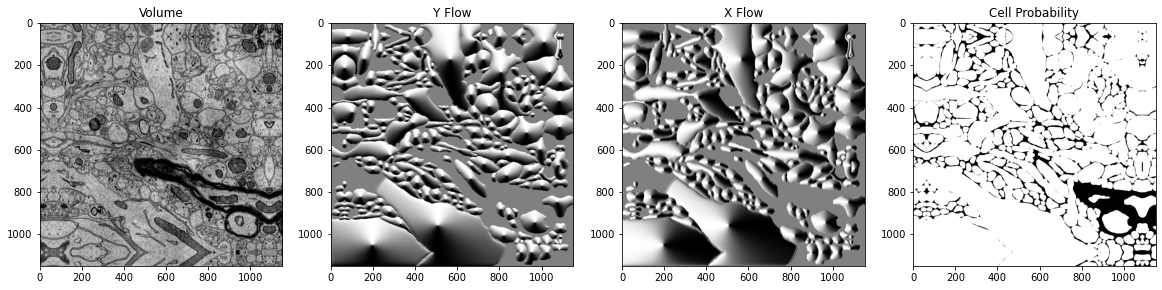

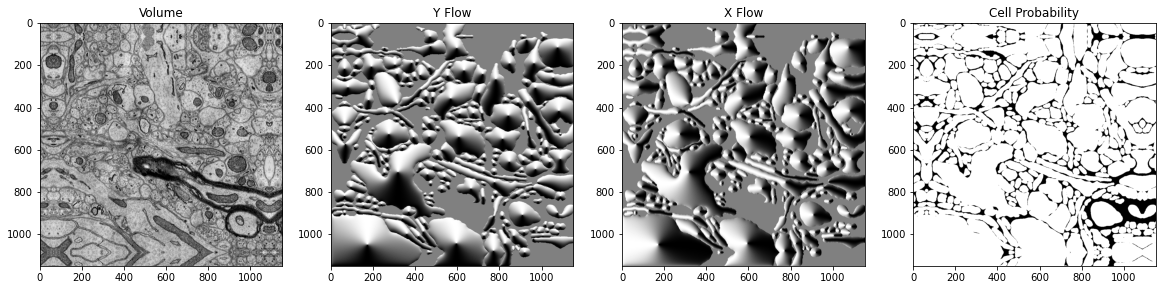

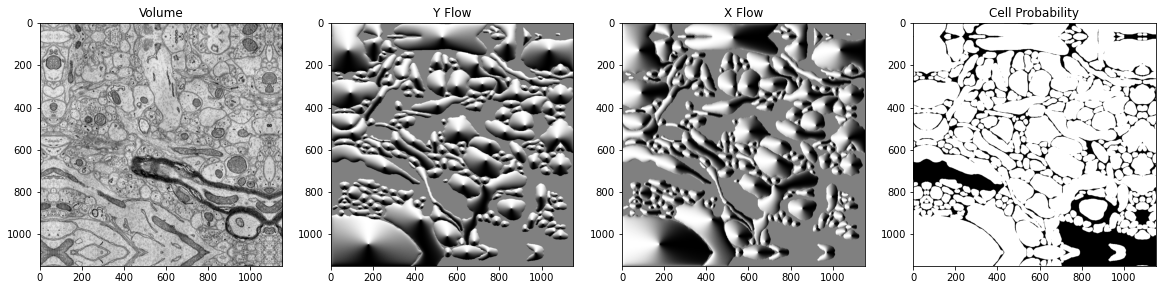

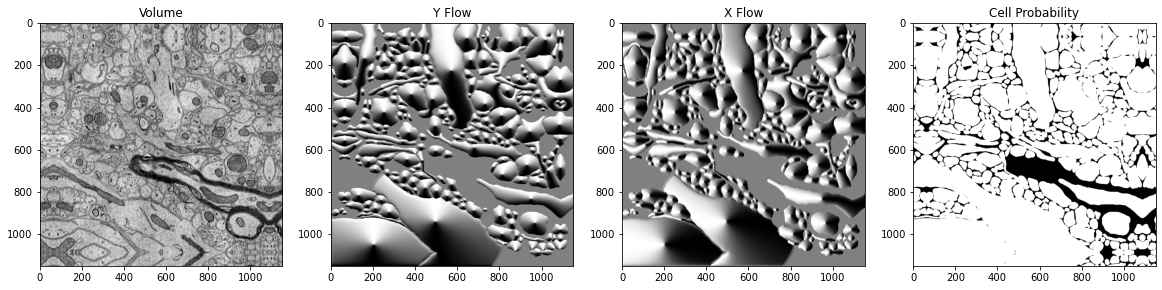

In [8]:
visualize = visualize_2d if cfg.DATASET.DO_2D else visualize_3d
visualize()